In [1]:
from pathlib import Path

import geopandas
import geopandas as gpd
import pandas
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


# TODO whole overlapping period?

# U for Uber, T for T4c, O for OpenStreetMap
UBASEPATH = Path("/iarai/public/t4c/uber")
TBASEPATH = Path("/iarai/public/t4c/data_pipeline/release20221028_historic_uber")
OBASEPATH = Path("/iarai/public/t4c/osm")
CITY = "berlin"
DAYTIME_START_HOUR = 8
DAYTIME_END_HOUR = 18
DAYTIME_HOURS = DAYTIME_END_HOUR - DAYTIME_START_HOUR

In [2]:
gen_gpkg = True

In [3]:
highway_ordering = [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
    "unclassified",
    "residential",
    "living_street",
    "service",
    "cycleway",
    "road",
    "construction",
]

In [4]:
plt.rcParams["axes.labelsize"] = 24

In [5]:
# simplified_filter = lambda hw: hw not in ['residential', 'living_street', 'service', 'road']
simplified_filter = lambda hw: hw in [
    "motorway",
    "motorway_link",
    "trunk",
    "trunk_link",
    "primary",
    "primary_link",
    "secondary",
    "secondary_link",
    "tertiary",
    "tertiary_link",
]

In [6]:
def osm_color_palette():
    for c in ["#e892a2", "#e892a2", "#f9b29c", "#f9b29c", "#fcd6a4", "#fcd6a4", "#f7fabf", "#f7fabf"] + ["white"] * 99:
        yield c

## Load Uber segment speeds

In [7]:
uspeeds_df = pandas.read_parquet(UBASEPATH / "movement-speeds-hourly-berlin-2019-2.parquet")
# uspeeds_df['speed_kph_mean'] = uspeeds_df['speed_mph_mean'] * 1.60934
uspeeds_df = uspeeds_df.rename(columns={"osm_start_node_id": "u", "osm_end_node_id": "v", "osm_way_id": "osmid"})
uspeeds_df["gkey"] = [f"{u}_{v}_{osmid}" for u, v, osmid in zip(uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["osmid"])]
uspeeds_df

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,u,v,speed_kph_mean,speed_kph_stddev,gkey
0,2019,2,15,8,2019-02-15T07:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,43.059,10.491,235637275_235637281_30709742
1,2019,2,15,20,2019-02-15T19:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,40.789,9.829,235637275_235637281_30709742
2,2019,2,25,9,2019-02-25T08:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,44.938,5.270,235637275_235637281_30709742
3,2019,2,15,9,2019-02-15T08:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,46.525,7.483,235637275_235637281_30709742
4,2019,2,15,14,2019-02-15T13:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,41.158,5.223,235637275_235637281_30709742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668433,2019,2,9,3,2019-02-09T02:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,49.142,4.479,1277848884_27306422_4446505
1668434,2019,2,9,0,2019-02-08T23:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,50.208,9.834,1277848884_27306422_4446505
1668435,2019,2,7,10,2019-02-07T09:00:00.000Z,096727bb10e8a3a8e2ddec40f6cef865d70fd09a,e8de6f3ca9b2ee93d65d2032f8fb273b8460b539,4abbcb68cb49784af136e89c0d6fbcf14796820b,4623430,29365140,29365090,33.913,4.781,29365140_29365090_4623430
1668436,2019,2,7,9,2019-02-07T08:00:00.000Z,096727bb10e8a3a8e2ddec40f6cef865d70fd09a,e8de6f3ca9b2ee93d65d2032f8fb273b8460b539,4abbcb68cb49784af136e89c0d6fbcf14796820b,4623430,29365140,29365090,34.595,4.885,29365140_29365090_4623430


## Load our segment speeds

In [8]:
tspeeds_l = []
for i in range(1, 8):
    f = TBASEPATH / "speed_classes" / CITY / f"speed_classes_2019-02-{i:02d}.parquet"
    print(f)
    df = pd.read_parquet(f)
    df["date"] = df["day"]
    df["year"] = 2019
    df["month"] = 2
    df["day"] = i
    df["hour"] = df["t"] // 4
    df = (
        df[["u", "v", "gkey", "year", "month", "day", "hour", "volume_class", "volume", "median_speed_kph", "free_flow_kph"]]
        .groupby(by=["u", "v", "gkey", "year", "month", "day", "hour"])
        .mean()
        .reset_index()
    )
    tspeeds_l.append(df)
tspeeds_df = pandas.concat(tspeeds_l)
# tspeeds_df = tspeeds_df.rename(columns={'osmid': 'osm_way_id'})
tspeeds_df

/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-01.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-02.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-03.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-04.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-05.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-06.parquet
/iarai/public/t4c/data_pipeline/release20221028_historic_uber/speed_classes/berlin/speed_classes_2019-02-07.parquet


,u,v,gkey,year,month,day,hour,volume_class,volume,median_speed_kph,free_flow_kph
0,172546,530313,172546_530313_24295532,2019,2,1,0,4.000000,7.500000,48.235294,48.156863
1,172546,530313,172546_530313_24295532,2019,2,1,1,4.000000,4.000000,48.235294,48.156863
2,172546,530313,172546_530313_24295532,2019,2,1,2,3.000000,3.000000,44.235294,48.156863
3,172546,530313,172546_530313_24295532,2019,2,1,4,3.000000,3.000000,44.705882,48.156863
4,172546,530313,172546_530313_24295532,2019,2,1,5,1.000000,2.000000,47.058824,48.156863
...,...,...,...,...,...,...,...,...,...,...,...
366360,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,19,5.000000,12.333333,37.098039,42.352941
366361,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,20,3.000000,3.666667,41.254902,42.352941
366362,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,21,1.666667,2.666667,41.568627,42.352941
366363,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,22,5.000000,8.500000,32.470588,42.352941


In [9]:
u_ids = set(zip(uspeeds_df["u"], uspeeds_df["v"], uspeeds_df["gkey"]))
u_ids

{(2902117307, 197333837, '2902117307_197333837_286529723'),
 (734451594, 29218293, '734451594_29218293_455097481'),
 (3949521958, 1003648310, '3949521958_1003648310_394366520'),
 (4817785844, 33148400, '4817785844_33148400_4377141'),
 (35209646, 1352425428, '35209646_1352425428_431551348'),
 (6299641507, 4865349510, '6299641507_4865349510_4611772'),
 (29271696, 29271697, '29271696_29271697_22741808'),
 (3463838835, 1211114211, '3463838835_1211114211_339201251'),
 (26754340, 26703741, '26754340_26703741_158023905'),
 (1176703855, 29276778, '1176703855_29276778_188865524'),
 (26662429, 30427948, '26662429_30427948_23720975'),
 (5239619471, 26823034, '5239619471_26823034_28497262'),
 (26708457, 3388008849, '26708457_3388008849_35583972'),
 (673868308, 359390910, '673868308_359390910_42732336'),
 (1837885687, 673876053, '1837885687_673876053_176112922'),
 (26724453, 3801122320, '26724453_3801122320_185779390'),
 (681294513, 150734364, '681294513_150734364_180797804'),
 (31259962, 183889682

In [10]:
t_ids = set(zip(tspeeds_df["u"], tspeeds_df["v"], tspeeds_df["gkey"]))
t_ids

{(734451594, 29218293, '734451594_29218293_455097481'),
 (2902117307, 197333837, '2902117307_197333837_286529723'),
 (3949521958, 1003648310, '3949521958_1003648310_394366520'),
 (4817785844, 33148400, '4817785844_33148400_4377141'),
 (35209646, 1352425428, '35209646_1352425428_431551348'),
 (29271696, 29271697, '29271696_29271697_22741808'),
 (3463838835, 1211114211, '3463838835_1211114211_339201251'),
 (26754340, 26703741, '26754340_26703741_158023905'),
 (26662429, 30427948, '26662429_30427948_23720975'),
 (5239619471, 26823034, '5239619471_26823034_28497262'),
 (26708457, 3388008849, '26708457_3388008849_35583972'),
 (673868308, 359390910, '673868308_359390910_42732336'),
 (1837885687, 673876053, '1837885687_673876053_176112922'),
 (26724453, 3801122320, '26724453_3801122320_185779390'),
 (681294513, 150734364, '681294513_150734364_180797804'),
 (31259962, 1838896820, '31259962_1838896820_186606611'),
 (1075303535, 16541470, '1075303535_16541470_38245747'),
 (1600833478, 4842240207

In [11]:
assert t_ids.issubset(u_ids)

In [12]:
# for u,v in u_uv - t_uv:
#     print(f"https://www.openstreetmap.org/node/{u}")
#     print(f"https://www.openstreetmap.org/node/{v}")
#     break

## Restrict to daytime only

In [13]:
tspeeds_df = tspeeds_df[(tspeeds_df["hour"] >= DAYTIME_START_HOUR) & (tspeeds_df["hour"] < DAYTIME_END_HOUR)]
tspeeds_df

,u,v,gkey,year,month,day,hour,volume_class,volume,median_speed_kph,free_flow_kph
7,172546,530313,172546_530313_24295532,2019,2,1,8,5.0,12.000000,42.849673,48.156863
8,172546,530313,172546_530313_24295532,2019,2,1,9,3.5,6.500000,43.764706,48.156863
9,172546,530313,172546_530313_24295532,2019,2,1,10,4.0,6.500000,44.529412,48.156863
10,172546,530313,172546_530313_24295532,2019,2,1,11,5.0,14.750000,39.529412,48.156863
11,172546,530313,172546_530313_24295532,2019,2,1,12,4.5,11.000000,39.137255,48.156863
...,...,...,...,...,...,...,...,...,...,...,...
366354,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,13,5.0,30.500000,21.352941,42.352941
366355,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,14,4.5,23.250000,27.921569,42.352941
366356,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,15,5.0,21.333333,20.549020,42.352941
366357,6173378378,426425008,6173378378_426425008_132105452,2019,2,7,16,5.0,29.500000,27.156863,42.352941


In [14]:
uspeeds_df = uspeeds_df[(uspeeds_df["hour"] >= DAYTIME_START_HOUR) & (uspeeds_df["hour"] < DAYTIME_END_HOUR)]
uspeeds_df

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osmid,u,v,speed_kph_mean,speed_kph_stddev,gkey
0,2019,2,15,8,2019-02-15T07:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,43.059,10.491,235637275_235637281_30709742
2,2019,2,25,9,2019-02-25T08:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,44.938,5.270,235637275_235637281_30709742
3,2019,2,15,9,2019-02-15T08:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,46.525,7.483,235637275_235637281_30709742
4,2019,2,15,14,2019-02-15T13:00:00.000Z,f50b8a5ca0afcdd31eb48403172284dbc42f2aeb,dc072f474bcbf30d75bd3b1e42974396af504bbb,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,30709742,235637275,235637281,41.158,5.223,235637275_235637281_30709742
5,2019,2,16,17,2019-02-16T16:00:00.000Z,1f4bccb7a80046e3cd483789f351efe99e612d1a,f61823a7db684f4f2c94e9ff25da7e6710d95c76,32c9d31816ecf0fde2586bab37995d06ad5f6f3e,169753571,1813307792,235637281,32.706,14.846,1813307792_235637281_169753571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668425,2019,2,10,15,2019-02-10T14:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,40.878,4.703,1277848884_27306422_4446505
1668430,2019,2,11,9,2019-02-11T08:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,38.541,7.179,1277848884_27306422_4446505
1668431,2019,2,23,12,2019-02-23T11:00:00.000Z,ff8a397700e1b9293bad2c93cd1a03aedf5ae6f5,9a51ec7772c9bbf6375eeace41d2a4a62cca64e3,7205366afb085f05d29e3698481f57b08693cd30,4446505,1277848884,27306422,50.068,4.174,1277848884_27306422_4446505
1668435,2019,2,7,10,2019-02-07T09:00:00.000Z,096727bb10e8a3a8e2ddec40f6cef865d70fd09a,e8de6f3ca9b2ee93d65d2032f8fb273b8460b539,4abbcb68cb49784af136e89c0d6fbcf14796820b,4623430,29365140,29365090,33.913,4.781,29365140_29365090_4623430


## Counts/densityfor both

In [15]:
ucounts = uspeeds_df.groupby(["u", "v", "gkey"]).agg(count=("speed_kph_mean", "count"), speed_kph_mean=("speed_kph_mean", "first")).reset_index()
ucounts

,u,v,gkey,count,speed_kph_mean
0,172546,530313,172546_530313_24295532,1,48.960
1,172558,172559,172558_172559_160130963,4,35.416
2,172559,29688040,172559_29688040_160130963,4,31.734
3,172562,530351,172562_530351_4804203,6,28.113
4,172562,6313308067,172562_6313308067_28427149,2,39.610
...,...,...,...,...,...
13721,6565966745,1667142764,6565966745_1667142764_11103963,3,40.263
13722,6565966757,21441737,6565966757_21441737_41927333,50,32.836
13723,6565966757,26752062,6565966757_26752062_41927333,39,21.198
13724,6566911649,5514269239,6566911649_5514269239_4597379,1,26.269


In [16]:
tcounts = (
    tspeeds_df.groupby(["u", "v", "gkey"])
    .agg(count=("median_speed_kph", "count"), median_speed_kph=("median_speed_kph", "first"), mean_volume=("volume", "mean"))
    .reset_index()[["u", "v", "gkey", "count", "median_speed_kph", "mean_volume"]]
)
tcounts

,u,v,gkey,count,median_speed_kph,mean_volume
0,172546,530313,172546_530313_24295532,69,42.849673,9.735507
1,172558,172559,172558_172559_160130963,70,42.901961,36.200000
2,172559,29688040,172559_29688040_160130963,70,49.647059,59.602381
3,172562,530351,172562_530351_4804203,70,19.627451,45.914286
4,172564,530185,172564_530185_4432669,70,32.186275,35.626190
...,...,...,...,...,...,...
16224,6171409045,6171409044,6171409045_6171409044_71143837,70,39.823529,29.261905
16225,6172685050,26745400,6172685050_26745400_417807344,70,26.588235,20.086905
16226,6172693100,26746095,6172693100_26746095_16943617,70,29.235294,14.295238
16227,6173378369,426425009,6173378369_426425009_132105452,68,22.601307,32.180147


In [17]:
num_slots_t_speeds = len(set(zip(tspeeds_df["year"], tspeeds_df["month"], tspeeds_df["day"], tspeeds_df["hour"])))
num_slots_t_speeds

70

In [18]:
num_slots_t_speeds / DAYTIME_HOURS

7.0

In [19]:
assert num_slots_t_speeds % DAYTIME_HOURS == 0

In [20]:
tcounts["density"] = tcounts["count"] / num_slots_t_speeds
tcounts

,u,v,gkey,count,median_speed_kph,mean_volume,density
0,172546,530313,172546_530313_24295532,69,42.849673,9.735507,0.985714
1,172558,172559,172558_172559_160130963,70,42.901961,36.200000,1.000000
2,172559,29688040,172559_29688040_160130963,70,49.647059,59.602381,1.000000
3,172562,530351,172562_530351_4804203,70,19.627451,45.914286,1.000000
4,172564,530185,172564_530185_4432669,70,32.186275,35.626190,1.000000
...,...,...,...,...,...,...,...
16224,6171409045,6171409044,6171409045_6171409044_71143837,70,39.823529,29.261905,1.000000
16225,6172685050,26745400,6172685050_26745400_417807344,70,26.588235,20.086905,1.000000
16226,6172693100,26746095,6172693100_26746095_16943617,70,29.235294,14.295238,1.000000
16227,6173378369,426425009,6173378369_426425009_132105452,68,22.601307,32.180147,0.971429


In [21]:
len(tcounts)

16229

In [22]:
(tcounts["count"] == 0).sum()

0

In [23]:
num_slots_u_speeds = len(set(zip(uspeeds_df["year"], uspeeds_df["month"], uspeeds_df["day"], uspeeds_df["hour"])))
num_slots_u_speeds

280

In [24]:
num_slots_u_speeds / DAYTIME_HOURS

28.0

In [25]:
assert num_slots_u_speeds % DAYTIME_HOURS == 0

In [26]:
ucounts["density"] = ucounts["count"] / num_slots_u_speeds
ucounts

,u,v,gkey,count,speed_kph_mean,density
0,172546,530313,172546_530313_24295532,1,48.960,0.003571
1,172558,172559,172558_172559_160130963,4,35.416,0.014286
2,172559,29688040,172559_29688040_160130963,4,31.734,0.014286
3,172562,530351,172562_530351_4804203,6,28.113,0.021429
4,172562,6313308067,172562_6313308067_28427149,2,39.610,0.007143
...,...,...,...,...,...,...
13721,6565966745,1667142764,6565966745_1667142764_11103963,3,40.263,0.010714
13722,6565966757,21441737,6565966757_21441737_41927333,50,32.836,0.178571
13723,6565966757,26752062,6565966757_26752062_41927333,39,21.198,0.139286
13724,6566911649,5514269239,6566911649_5514269239_4597379,1,26.269,0.003571


In [27]:
len(ucounts)

13726

In [28]:
(ucounts["count"] == 0).sum()

0

## Merge with historic OSM data for UBER

In [29]:
gdf_nodes = gpd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_nodes.parquet")
gdf_nodes

,node_id,x,y,geometry
0,172546,13.352255,52.567738,POINT (13.35225 52.56774)
1,172558,13.337368,52.558781,POINT (13.33737 52.55878)
2,172559,13.336074,52.559517,POINT (13.33607 52.55952)
3,172562,13.330664,52.562600,POINT (13.33066 52.56260)
4,172564,13.327708,52.564046,POINT (13.32771 52.56405)
...,...,...,...,...
12650,6171409045,13.399112,52.508193,POINT (13.39911 52.50819)
12651,6172685050,13.362564,52.505849,POINT (13.36256 52.50585)
12652,6172693100,13.368124,52.505898,POINT (13.36812 52.50590)
12653,6173378369,13.491984,52.501171,POINT (13.49198 52.50117)


In [30]:
gdf_edges = gpd.read_parquet(TBASEPATH / "road_graph" / CITY / "road_graph_edges.parquet")
gdf_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,46.759468,"LINESTRING (13.35225 52.56774, 13.35266 52.56784)",Emmentaler Straße
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,164.463017,"LINESTRING (13.33737 52.55878, 13.33725 52.558...",Müllerstraße
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,153.966487,"LINESTRING (13.33607 52.55952, 13.33578 52.559...",Müllerstraße
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,23.283372,"LINESTRING (13.33066 52.56260, 13.33047 52.56253)",
4,172564_530185_4432669,172564,530185,4432669,50.0,50,secondary,,,,44.345716,"LINESTRING (13.32771 52.56405, 13.32759 52.563...",Kurt-Schumacher-Platz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409045_6171409044_71143837,6171409045,6171409044,71143837,50.0,50,secondary,,,,71.576136,"LINESTRING (13.39911 52.50819, 13.39949 52.50873)",Axel-Springer-Straße
16275,6172685050_26745400_417807344,6172685050,26745400,417807344,50.0,50,residential,,,,5.821343,"LINESTRING (13.36256 52.50585, 13.36258 52.50590)",Bendlerbrücke
16276,6172693100_26746095_16943617,6172693100,26746095,16943617,30.0,30,primary,,,,9.151821,"LINESTRING (13.36812 52.50590, 13.36809 52.50582)",Potsdamer Straße
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,3.764184,"LINESTRING (13.49198 52.50117, 13.49202 52.50116)",Lückstraße


In [31]:
gdf_edges = gdf_edges.merge(gdf_nodes, left_on="u", right_on="node_id", suffixes=["", "_u"]).merge(
    gdf_nodes, left_on="v", right_on="node_id", suffixes=["", "_v"]
)
gdf_edges.rename(columns={"x": "x_u", "y": "y_u"}, inplace=True)
del gdf_edges["geometry_u"]
del gdf_edges["geometry_v"]
gdf_edges

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,length_meters,geometry,name,node_id,x_u,y_u,node_id_v,x_v,y_v
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,46.759468,"LINESTRING (13.35225 52.56774, 13.35266 52.56784)",Emmentaler Straße,172546,13.352255,52.567738,530313,13.352664,52.567835
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,164.463017,"LINESTRING (13.33737 52.55878, 13.33725 52.558...",Müllerstraße,172558,13.337368,52.558781,172559,13.336074,52.559517
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,153.966487,"LINESTRING (13.33607 52.55952, 13.33578 52.559...",Müllerstraße,172559,13.336074,52.559517,29688040,13.334868,52.560216
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,23.283372,"LINESTRING (13.33066 52.56260, 13.33047 52.56253)",,172562,13.330664,52.562600,530351,13.330466,52.562532
4,2869415442_530351_283022996,2869415442,530351,283022996,50.0,50,secondary,,,,75.539975,"LINESTRING (13.32987 52.56287, 13.33000 52.562...",Scharnweberstraße,2869415442,13.329873,52.562873,530351,13.330466,52.562532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409041_6171409040_335462871,6171409041,6171409040,335462871,50.0,50,secondary,,,,81.025436,"LINESTRING (13.39861 52.50751, 13.39905 52.50811)",Axel-Springer-Straße,6171409041,13.398614,52.507512,6171409040,13.399054,52.508109
16275,6171409045_6171409040_335462871,6171409045,6171409040,335462871,50.0,50,secondary,,,,11.137605,"LINESTRING (13.39911 52.50819, 13.39905 52.50811)",Axel-Springer-Straße,6171409045,13.399112,52.508193,6171409040,13.399054,52.508109
16276,6171409044_6171409042_24214231,6171409044,6171409042,24214231,50.0,50,secondary,,,,52.700663,"LINESTRING (13.39949 52.50873, 13.39965 52.508...",Axel-Springer-Straße,6171409044,13.399490,52.508729,6171409042,13.399812,52.509086
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,3.764184,"LINESTRING (13.49198 52.50117, 13.49202 52.50116)",Lückstraße,6173378369,13.491984,52.501171,426425009,13.492017,52.501164


In [32]:
# Berlin
y_min, y_max, x_min, x_max = 52.35900, 52.85400, 13.18900, 13.62500

In [33]:
def in_bb(x, y):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

In [34]:
gdf_edges["in_bb"] = [
    (in_bb(x_u, y_u) or in_bb(x_v, y_v)) for x_u, y_u, x_v, y_v in zip(gdf_edges["x_u"], gdf_edges["y_u"], gdf_edges["x_v"], gdf_edges["y_v"])
]

In [35]:
gdf_edges.groupby("in_bb").agg(count=("gkey", "count"))

,count
in_bb,
False,50
True,16229


In [36]:
gdf_ucounts_merged = gdf_edges.merge(ucounts, on=["u", "v", "gkey"], how="left")
gdf_ucounts_merged[["count", "density"]] = gdf_ucounts_merged[["count", "density"]].fillna(0.0)
gdf_ucounts_merged

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,...,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb,count,speed_kph_mean,density
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,...,172546,13.352255,52.567738,530313,13.352664,52.567835,True,1.0,48.960,0.003571
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,...,172558,13.337368,52.558781,172559,13.336074,52.559517,True,4.0,35.416,0.014286
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,...,172559,13.336074,52.559517,29688040,13.334868,52.560216,True,4.0,31.734,0.014286
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,...,172562,13.330664,52.562600,530351,13.330466,52.562532,True,6.0,28.113,0.021429
4,2869415442_530351_283022996,2869415442,530351,283022996,50.0,50,secondary,,,,...,2869415442,13.329873,52.562873,530351,13.330466,52.562532,True,3.0,19.235,0.010714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409041_6171409040_335462871,6171409041,6171409040,335462871,50.0,50,secondary,,,,...,6171409041,13.398614,52.507512,6171409040,13.399054,52.508109,True,193.0,41.373,0.689286
16275,6171409045_6171409040_335462871,6171409045,6171409040,335462871,50.0,50,secondary,,,,...,6171409045,13.399112,52.508193,6171409040,13.399054,52.508109,True,216.0,47.251,0.771429
16276,6171409044_6171409042_24214231,6171409044,6171409042,24214231,50.0,50,secondary,,,,...,6171409044,13.399490,52.508729,6171409042,13.399812,52.509086,True,213.0,50.891,0.760714
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,...,6173378369,13.491984,52.501171,426425009,13.492017,52.501164,True,0.0,NaN,0.000000


In [37]:
assert type(gdf_ucounts_merged) == geopandas.geodataframe.GeoDataFrame

In [38]:
gdf_tcounts_merged = gdf_edges.merge(tcounts, on=["u", "v", "gkey"], how="left")
gdf_tcounts_merged[["count", "density"]] = gdf_tcounts_merged[["count", "density"]].fillna(0.0)
gdf_tcounts_merged

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,...,x_u,y_u,node_id_v,x_v,y_v,in_bb,count,median_speed_kph,mean_volume,density
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,...,13.352255,52.567738,530313,13.352664,52.567835,True,69.0,42.849673,9.735507,0.985714
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,...,13.337368,52.558781,172559,13.336074,52.559517,True,70.0,42.901961,36.200000,1.000000
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,...,13.336074,52.559517,29688040,13.334868,52.560216,True,70.0,49.647059,59.602381,1.000000
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,...,13.330664,52.562600,530351,13.330466,52.562532,True,70.0,19.627451,45.914286,1.000000
4,2869415442_530351_283022996,2869415442,530351,283022996,50.0,50,secondary,,,,...,13.329873,52.562873,530351,13.330466,52.562532,True,70.0,20.235294,91.502381,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409041_6171409040_335462871,6171409041,6171409040,335462871,50.0,50,secondary,,,,...,13.398614,52.507512,6171409040,13.399054,52.508109,True,70.0,35.166667,65.184524,1.000000
16275,6171409045_6171409040_335462871,6171409045,6171409040,335462871,50.0,50,secondary,,,,...,13.399112,52.508193,6171409040,13.399054,52.508109,True,70.0,43.058824,22.725000,1.000000
16276,6171409044_6171409042_24214231,6171409044,6171409042,24214231,50.0,50,secondary,,,,...,13.399490,52.508729,6171409042,13.399812,52.509086,True,70.0,41.794118,42.692857,1.000000
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,...,13.491984,52.501171,426425009,13.492017,52.501164,True,68.0,22.601307,32.180147,0.971429


### Write counts/density to parquet/gpkg

In [39]:
if gen_gpkg:
    gdf_ucounts_merged.to_parquet(f"{CITY}_ucounts.parquet")
    gdf_ucounts_merged.to_file(f"{CITY}_ucounts.gpkg", driver="GPKG", layer="edges")

In [40]:
if gen_gpkg:
    gdf_tcounts_merged.to_parquet(f"{CITY}_tcounts.parquet")
    gdf_tcounts_merged.to_file(f"{CITY}_tcounts.gpkg", driver="GPKG", layer="edges")

## Density differences

In [41]:
gdf_ut_counts_merged = gdf_tcounts_merged.merge(gdf_ucounts_merged, on=["u", "v", "gkey"], suffixes=["", "_u"], how="outer")
# workaround (if we use suffixes =["_t", "_u"]), we get a plain pandas frame...
gdf_ut_counts_merged.rename(columns={"density": "density_t", "count": "count_t"}, inplace=True)
gdf_ut_counts_merged[["count_t", "density_t"]] = gdf_ut_counts_merged[["count_t", "density_t"]].fillna(0.0)
gdf_ut_counts_merged["density_diff"] = gdf_ut_counts_merged["density_t"] - gdf_ut_counts_merged["density_u"]
del gdf_ut_counts_merged["geometry_u"]
gdf_ut_counts_merged

,gkey,u,v,osmid,speed_kph,maxspeed,highway,oneway,lanes,tunnel,...,x_u_u,y_u_u,node_id_v_u,x_v_u,y_v_u,in_bb_u,count_u,speed_kph_mean,density_u,density_diff
0,172546_530313_24295532,172546,530313,24295532,50.0,50,secondary,,,,...,13.352255,52.567738,530313,13.352664,52.567835,True,1.0,48.960,0.003571,0.982143
1,172558_172559_160130963,172558,172559,160130963,50.0,50,primary,,,,...,13.337368,52.558781,172559,13.336074,52.559517,True,4.0,35.416,0.014286,0.985714
2,172559_29688040_160130963,172559,29688040,160130963,50.0,50,primary,,,,...,13.336074,52.559517,29688040,13.334868,52.560216,True,4.0,31.734,0.014286,0.985714
3,172562_530351_4804203,172562,530351,4804203,50.0,50,primary_link,,,,...,13.330664,52.562600,530351,13.330466,52.562532,True,6.0,28.113,0.021429,0.978571
4,2869415442_530351_283022996,2869415442,530351,283022996,50.0,50,secondary,,,,...,13.329873,52.562873,530351,13.330466,52.562532,True,3.0,19.235,0.010714,0.989286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16274,6171409041_6171409040_335462871,6171409041,6171409040,335462871,50.0,50,secondary,,,,...,13.398614,52.507512,6171409040,13.399054,52.508109,True,193.0,41.373,0.689286,0.310714
16275,6171409045_6171409040_335462871,6171409045,6171409040,335462871,50.0,50,secondary,,,,...,13.399112,52.508193,6171409040,13.399054,52.508109,True,216.0,47.251,0.771429,0.228571
16276,6171409044_6171409042_24214231,6171409044,6171409042,24214231,50.0,50,secondary,,,,...,13.399490,52.508729,6171409042,13.399812,52.509086,True,213.0,50.891,0.760714,0.239286
16277,6173378369_426425009_132105452,6173378369,426425009,132105452,50.0,50,tertiary,,,,...,13.491984,52.501171,426425009,13.492017,52.501164,True,0.0,NaN,0.000000,0.971429


In [42]:
gdf_ut_counts_merged["in_bb"] = [
    (in_bb(x_u, y_u) or in_bb(x_v, y_v))
    for x_u, y_u, x_v, y_v in zip(gdf_ut_counts_merged["x_u"], gdf_ut_counts_merged["y_u"], gdf_ut_counts_merged["x_v"], gdf_ut_counts_merged["y_v"])
]

In [43]:
gdf_ut_counts_merged["sort_key"] = [highway_ordering.index(hw) for hw in gdf_ut_counts_merged["highway"]]
gdf_ut_counts_merged = gdf_ut_counts_merged.sort_values("sort_key")

In [44]:
assert gdf_ut_counts_merged["density_u"].isnull().sum() == 0
assert gdf_ut_counts_merged["density_t"].isnull().sum() == 0
assert type(gdf_ut_counts_merged) == geopandas.geodataframe.GeoDataFrame

In [45]:
if gen_gpkg:
    gdf_ut_counts_merged.to_parquet(f"{CITY}_utcounts.parquet")
    gdf_ut_counts_merged.to_file(f"{CITY}_utcounts.gpkg", driver="GPKG", layer="edges")

In [46]:
gdf_ut_counts_merged_by_hw_in_bb = (
    gdf_ut_counts_merged[gdf_ut_counts_merged["in_bb"] == True]
    .groupby("highway")
    .agg(count=("density_diff", "count"), mean_density_diff=("density_diff", "mean"))
    .reset_index()
)
gdf_ut_counts_merged_by_hw_in_bb["sort_key"] = [highway_ordering.index(hw) for hw in gdf_ut_counts_merged_by_hw_in_bb["highway"]]
gdf_ut_counts_merged_by_hw_in_bb = gdf_ut_counts_merged_by_hw_in_bb.sort_values("sort_key")
gdf_ut_counts_merged_by_hw_in_bb

,highway,count,mean_density_diff,sort_key
2,motorway,515,0.547753,0
3,motorway_link,384,0.921922,1
11,trunk,46,0.352174,2
4,primary,2919,0.737290,4
5,primary_link,15,0.795000,5
7,secondary,6464,0.821400,6
8,secondary_link,21,0.907823,7
9,tertiary,2780,0.907902,8
10,tertiary_link,2,0.973214,9
12,unclassified,56,0.560587,10


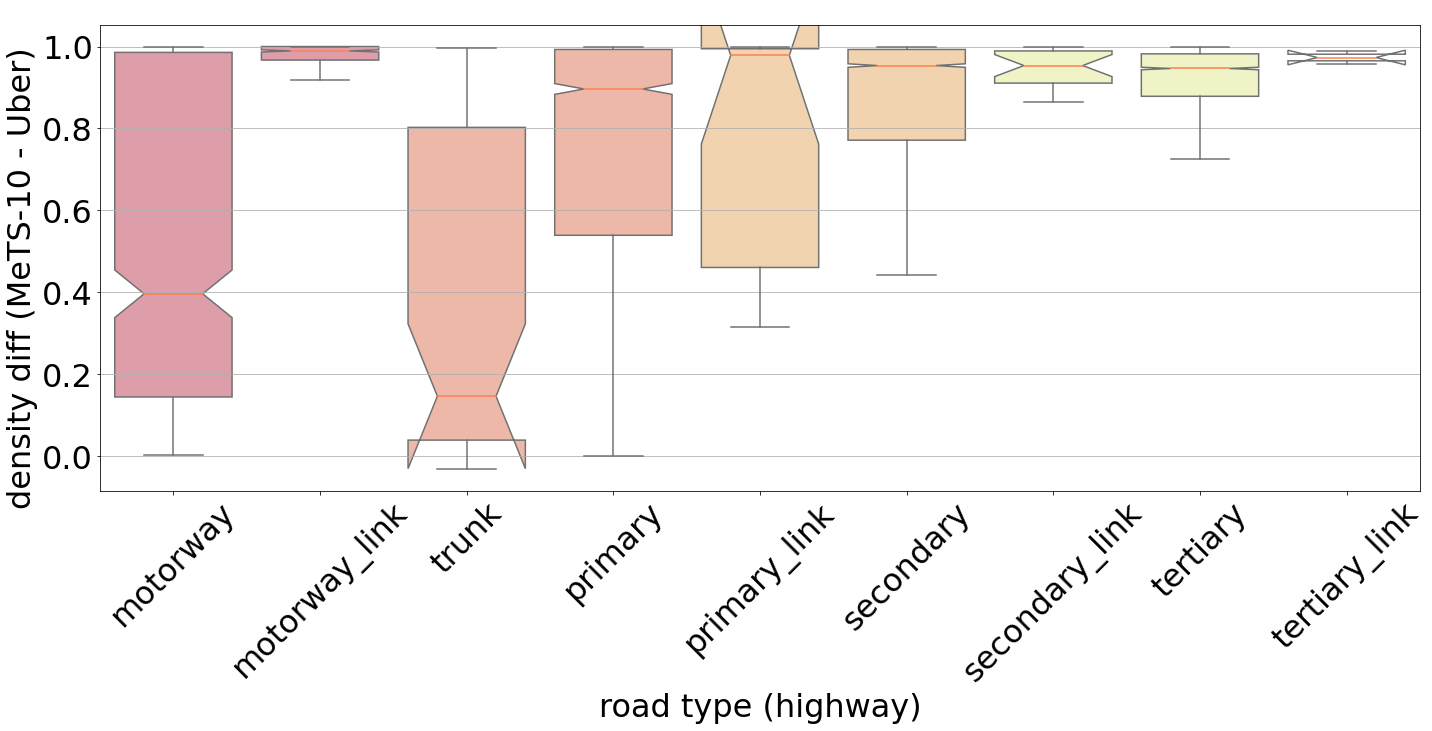

In [67]:
plt.rcParams["axes.labelsize"] = 32
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)

sns.boxplot(
    gdf_ut_counts_merged[(gdf_ut_counts_merged["in_bb"] == True) & ([simplified_filter(hw) for hw in gdf_ut_counts_merged["highway"]])],
    x="highway",
    y="density_diff",
    notch=True,
    sym="",
    palette=osm_color_palette(),
    medianprops={"color": "coral"},
    ax=ax,
)
# plt.rcParams["axes.labelsize"] = 24
ax.tick_params(axis="x", which="major", labelsize=24, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=24)
ax.tick_params(axis="x", which="major", labelsize=32, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=32)
ax.grid(axis="y")
ax.set(xlabel='road type (highway)',
       ylabel='density diff (MeTS-10 - Uber)    ')
plt.savefig(f"{CITY}_Uber_density_diff_barplot.pdf")

In [48]:
# TODO do we need full area at all?

## Density histograms and stats

In [49]:
# instead of un/pivoting.....
ucounts["src"] = "u"
tcounts["src"] = "t"
counts_all = pd.concat([ucounts.rename(columns={"speed_kph_mean": "speed"}), tcounts.rename(columns={"median_speed_kph": "speed"})])
counts_all = counts_all.merge(gdf_edges, on=["u", "v", "gkey"])
counts_all["sort_key"] = [highway_ordering.index(hw) for hw in counts_all["highway"]]
counts_all = counts_all.sort_values("sort_key")
counts_all["matching"] = [(u, v, gkey) in t_ids for u, v, gkey in zip(counts_all["u"], counts_all["v"], counts_all["gkey"])]

## Density histogram for both

In [50]:
def plot_and_stats(df, density_attr, speed_attr):
    fig, axs = plt.subplots(2, figsize=(10, 5), tight_layout=True)
    axs[0].hist(df[density_attr], bins=10)
    axs[0].set_xlabel(density_attr)
    axs[1].hist(df[speed_attr], bins=48)
    axs[1].set_xlabel(speed_attr)
    df_gr = df.groupby("highway").agg(
        {
            density_attr: ["count", "mean", "median", "min", "max", "std"],
            speed_attr: ["mean", "median", "min", "max", "std"],
            "speed_kph": ["mean", "median", "min", "max", "std"],
            "length_meters": ["mean", "median", "min", "max", "std"],
        }
    )
    df_gr["sort_key"] = [highway_ordering.index(hw) for hw in df_gr.reset_index()["highway"]]
    display(df_gr.sort_values("sort_key"))

### density over full area

<AxesSubplot:xlabel='highway', ylabel='density'>

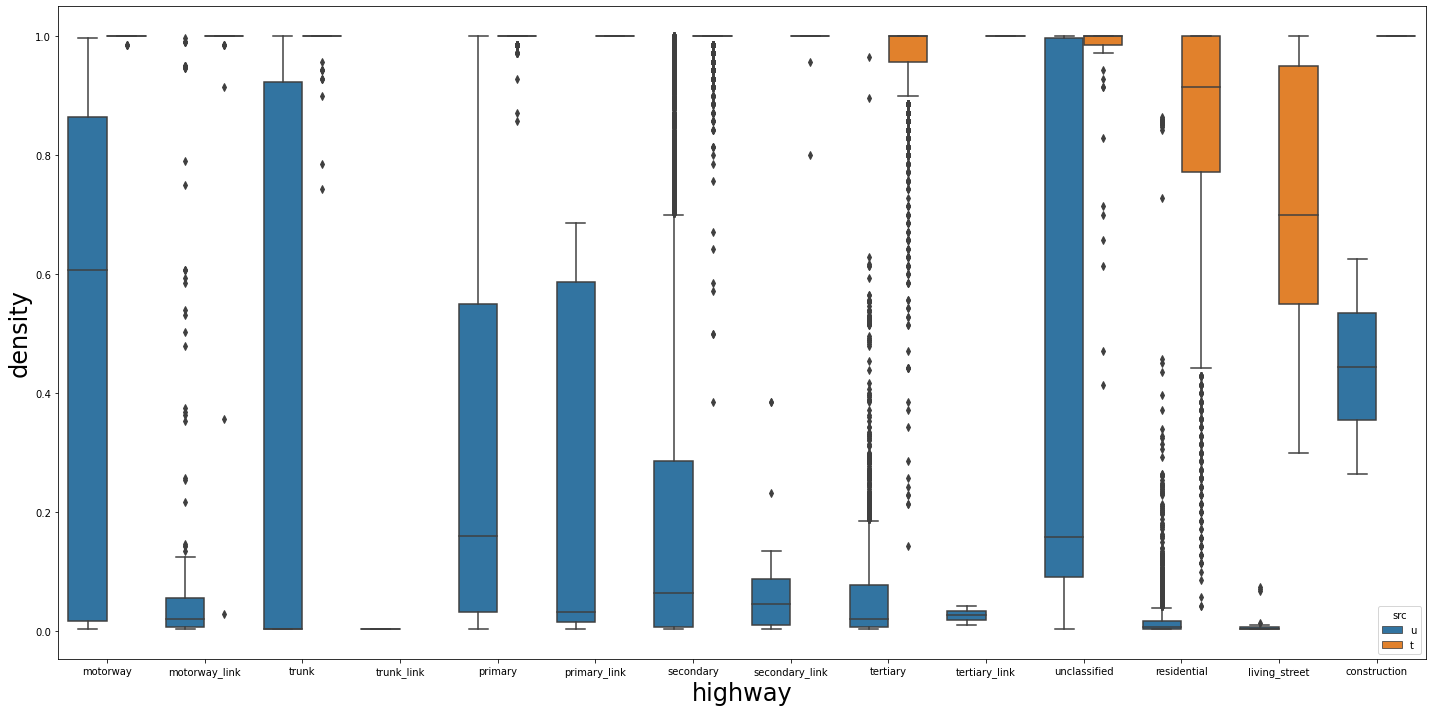

In [51]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(counts_all, x="highway", y="density", hue="src", ax=ax)
# TODO this looks fishy: motorway over full areay t should have 0 for everything ourside of the box - outer join?!

#### full area Uber

density_u                                                    \
                   count      mean    median       min       max       std   
highway                                                                      
motorway             515  0.452136  0.603571  0.000000  0.996429  0.398850   
motorway_link        384  0.073503  0.010714  0.000000  0.996429  0.199396   
trunk                 72  0.400496  0.003571  0.003571  1.000000  0.438777   
trunk_link             4  0.003571  0.003571  0.003571  0.003571  0.000000   
primary             2937  0.260694  0.100000  0.000000  1.000000  0.317334   
primary_link          15  0.205000  0.021429  0.000000  0.685714  0.284333   
secondary           6464  0.173373  0.035714  0.000000  1.000000  0.268567   
secondary_link        21  0.080612  0.042857  0.000000  0.385714  0.115449   
tertiary            2782  0.052530  0.010714  0.000000  0.964286  0.096918   
tertiary_link          2  0.026786  0.026786  0.010714  0.042857  0.022728   
unclassified          56  0.386352  0.103571  0.000000  1.000000  0.435268   
residential         2934  0.020559  0.003571  0.000000  0.864286  0.075306   
living_street         91  0.005259  0.003571  0.000000  0.075000  0.012715   
construction           2  0.444643  0.444643  0.264286  0.625000  0.255064   

               speed_kph_mean                            ... speed_kph        \
                         mean   median     min      max  ...    median   min   
highway                                                  ...                   
motorway            74.568341  75.8780   2.935  106.908  ...      80.0  40.0   
motorway_link       51.663332  56.3940   3.387   98.400  ...      60.0  40.0   
trunk               66.747278  66.8225  18.026   97.990  ...      65.0  50.0   
trunk_link          34.864250  32.5455  26.843   47.523  ...      30.0  30.0   
primary             36.366574  37.2540   2.980   65.727  ...      50.0  30.0   
primary_link        24.778667  24.0330  14.416   42.017  ...      50.0  30.0   
secondary           35.431155  36.6590   1.974   78.178  ...      50.0  10.0   
secondary_link      27.966579  27.5090  12.544   40.823  ...      50.0  50.0   
tertiary            32.731058  33.9420   2.493   61.958  ...      50.0  30.0   
tertiary_link       27.338000  27.3380  18.525   36.151  ...      50.0  50.0   
unclassified        34.149667  38.3665   7.530   53.987  ...      30.0  20.0   
residential         26.630028  26.9870   1.354   85.857  ...      30.0  10.0   
living_street       19.881698  18.8660   9.153   35.891  ...      50.0  50.0   
construction        28.029500  28.0295  16.602   39.457  ...      50.0  50.0   

                                 length_meters                         \
                  max        std          mean      median        min   
highway                                                                 
motorway        120.0  11.756390    269.542609  166.226147   3.007915   
motorway_link   120.0   9.972965    143.955006  116.380459  11.935410   
trunk           100.0  22.004410    337.387531  162.912065   3.422053   
trunk_link       30.0   0.000000     87.260292   54.245901  11.117889   
primary          70.0   6.012794    105.304730   71.958405   2.786192   
primary_link     60.0   7.745967     36.327633   23.283372  10.541186   
secondary        80.0   5.288577     91.430491   66.172522   2.294943   
secondary_link   50.0   0.000000     50.739361   27.290517  15.283966   
tertiary         80.0   8.125913     90.158813   65.808359   2.268041   
tertiary_link    50.0   0.000000     19.237726   19.237726  19.237726   
unclassified     50.0  10.263315     75.866782   46.096459   3.579474   
residential      50.0   7.686810    101.171479   77.107500   2.359982   
living_street    50.0   0.000000    111.376050   88.298721   3.659491   
construction     50.0   0.000000     36.719721   36.719721  36.719721   

                                        sort_key  
                        max       

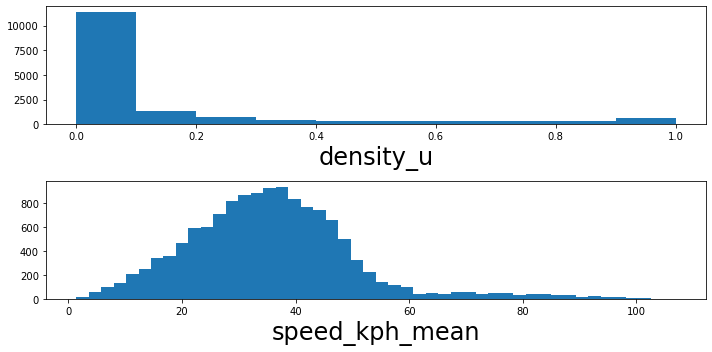

In [52]:
plot_and_stats(gdf_ut_counts_merged, "density_u", "speed_kph_mean")

#### density full area t4c

density_t                                               \
                   count      mean    median       min  max       std   
highway                                                                 
motorway             515  0.999889  1.000000  0.985714  1.0  0.001255   
motorway_link        384  0.995424  1.000000  0.028571  1.0  0.059525   
trunk                 72  0.624206  0.950000  0.000000  1.0  0.474480   
trunk_link             4  0.000000  0.000000  0.000000  0.0  0.000000   
primary             2937  0.993463  1.000000  0.000000  1.0  0.078151   
primary_link          15  1.000000  1.000000  1.000000  1.0  0.000000   
secondary           6464  0.994773  1.000000  0.385714  1.0  0.021511   
secondary_link        21  0.988435  1.000000  0.800000  1.0  0.044175   
tertiary            2782  0.959777  1.000000  0.000000  1.0  0.087741   
tertiary_link          2  1.000000  1.000000  1.000000  1.0  0.000000   
unclassified          56  0.946939  1.000000  0.414286  1.0  0.131883   
residential         2934  0.838977  0.914286  0.042857  1.0  0.199248   
living_street         91  0.717896  0.700000  0.300000  1.0  0.217141   
construction           2  1.000000  1.000000  1.000000  1.0  0.000000   

               median_speed_kph                                    ...  \
                           mean     median        min         max  ...   
highway                                                            ...   
motorway              70.527832  71.333333  17.176471  113.313725  ...   
motorway_link         60.758025  63.705882   9.882353  111.411765  ...   
trunk                 47.582552  44.205882  15.686275   90.405229  ...   
trunk_link                  NaN        NaN        NaN         NaN  ...   
primary               35.616691  35.137255   7.764706   75.647059  ...   
primary_link          31.358388  30.078431  18.176471   53.254902  ...   
secondary             34.768506  34.093137   3.764706   83.980392  ...   
secondary_link        28.506069  27.088235  11.294118   53.607843  ...   
tertiary              31.342068  30.588235   4.823529   90.764706  ...   
tertiary_link         22.632353  22.632353  14.500000   30.764706  ...   
unclassified          34.530987  36.794118   5.058824   50.450980  ...   
residential           25.604066  25.411765   1.411765   94.196078  ...   
living_street         20.208504  19.176471   4.235294   38.000000  ...   
construction          29.916667  29.916667  19.637255   40.196078  ...   

               speed_kph                         length_meters              \
                  median   min    max        std          mean      median   
highway                                                                      
motorway            80.0  40.0  120.0  11.756390    269.542609  166.226147   
motorway_link       60.0  40.0  120.0   9.972965    143.955006  116.380459   
trunk               65.0  50.0  100.0  22.004410    337.387531  162.912065   
trunk_link          30.0  30.0   30.0   0.000000     87.260292   54.245901   
primary             50.0  30.0   70.0   6.012794    105.304730   71.958405   
primary_link        50.0  30.0   60.0   7.745967     36.327633   23.283372   
secondary           50.0  10.0   80.0   5.288577     91.430491   66.172522   
secondary_link      50.0  50.0   50.0   0.000000     50.739361   27.290517   
tertiary            50.0  30.0   80.0   8.125913     90.158813   65.808359   
tertiary_link       50.0  50.0   50.0   0.000000     19.237726   19.237726   
unclassified        30.0  20.0   50.0  10.263315     75.866782   46.096459   
residential         30.0  10.0   50.0   7.686810    101.171479   77.107500   
living_street       50.0  50.0   50.0   0.000000    111.376050   88.298721   
construction        50.0  50.0   50.0   0.000000     36.719721   36.719721   

                                                   sort_key  
                      min          max         std           
highway                                                      
m

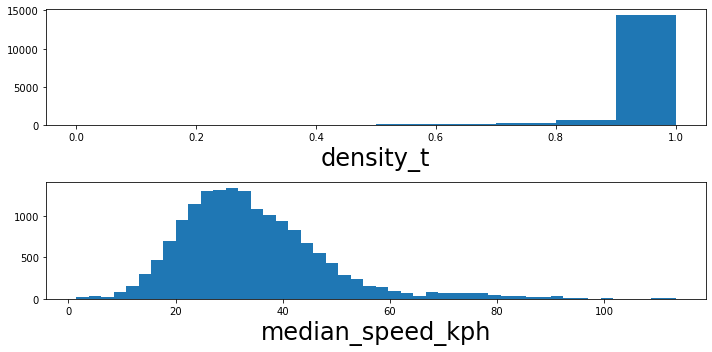

In [53]:
plot_and_stats(gdf_ut_counts_merged, "density_t", "median_speed_kph")

### density within bounding box

<AxesSubplot:xlabel='highway', ylabel='density'>

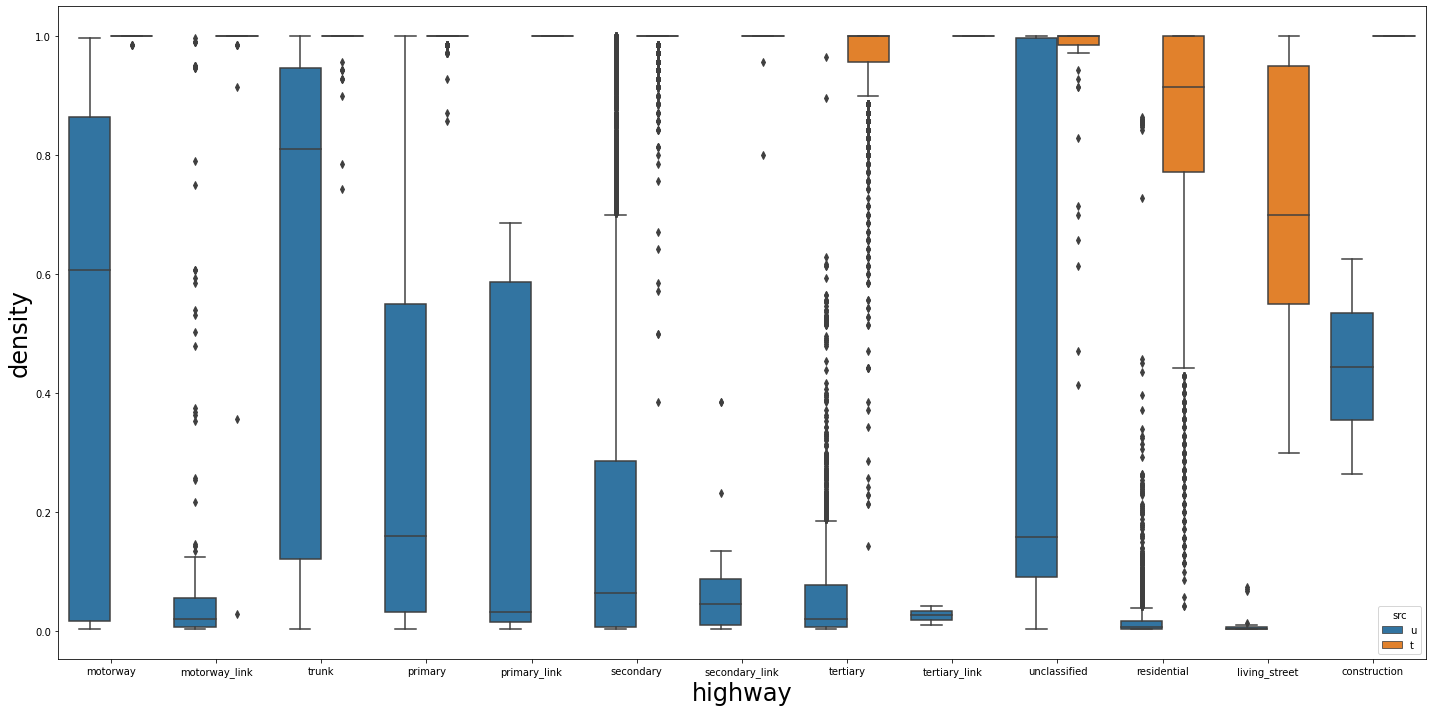

In [54]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(counts_all[counts_all["in_bb"] == True], x="highway", y="density", hue="src", ax=ax)

#### density bounding box Uber

density_u                                                    \
                   count      mean    median       min       max       std   
highway                                                                      
motorway             515  0.452136  0.603571  0.000000  0.996429  0.398850   
motorway_link        384  0.073503  0.010714  0.000000  0.996429  0.199396   
trunk                 46  0.624845  0.810714  0.003571  1.000000  0.401600   
primary             2919  0.262299  0.103571  0.000000  1.000000  0.317649   
primary_link          15  0.205000  0.021429  0.000000  0.685714  0.284333   
secondary           6464  0.173373  0.035714  0.000000  1.000000  0.268567   
secondary_link        21  0.080612  0.042857  0.000000  0.385714  0.115449   
tertiary            2780  0.052566  0.010714  0.000000  0.964286  0.096944   
tertiary_link          2  0.026786  0.026786  0.010714  0.042857  0.022728   
unclassified          56  0.386352  0.103571  0.000000  1.000000  0.435268   
residential         2934  0.020559  0.003571  0.000000  0.864286  0.075306   
living_street         91  0.005259  0.003571  0.000000  0.075000  0.012715   
construction           2  0.444643  0.444643  0.264286  0.625000  0.255064   

               speed_kph_mean                            ... speed_kph        \
                         mean   median     min      max  ...    median   min   
highway                                                  ...                   
motorway            74.568341  75.8780   2.935  106.908  ...      80.0  40.0   
motorway_link       51.663332  56.3940   3.387   98.400  ...      60.0  40.0   
trunk               54.900848  55.1225  18.026   84.125  ...      50.0  50.0   
primary             36.353103  37.2395   2.980   65.727  ...      50.0  30.0   
primary_link        24.778667  24.0330  14.416   42.017  ...      50.0  30.0   
secondary           35.431155  36.6590   1.974   78.178  ...      50.0  10.0   
secondary_link      27.966579  27.5090  12.544   40.823  ...      50.0  50.0   
tertiary            32.730167  33.9420   2.493   61.958  ...      50.0  30.0   
tertiary_link       27.338000  27.3380  18.525   36.151  ...      50.0  50.0   
unclassified        34.149667  38.3665   7.530   53.987  ...      30.0  20.0   
residential         26.630028  26.9870   1.354   85.857  ...      30.0  10.0   
living_street       19.881698  18.8660   9.153   35.891  ...      50.0  50.0   
construction        28.029500  28.0295  16.602   39.457  ...      50.0  50.0   

                                 length_meters                         \
                  max        std          mean      median        min   
highway                                                                 
motorway        120.0  11.756390    269.542609  166.226147   3.007915   
motorway_link   120.0   9.972965    143.955006  116.380459  11.935410   
trunk            80.0  11.395397    191.759709  113.983541   3.422053   
primary          70.0   6.030589    105.425675   71.958405   2.786192   
primary_link     60.0   7.745967     36.327633   23.283372  10.541186   
secondary        80.0   5.288577     91.430491   66.172522   2.294943   
secondary_link   50.0   0.000000     50.739361   27.290517  15.283966   
tertiary         80.0   8.128033     90.187089   65.808359   2.268041   
tertiary_link    50.0   0.000000     19.237726   19.237726  19.237726   
unclassified     50.0  10.263315     75.866782   46.096459   3.579474   
residential      50.0   7.686810    101.171479   77.107500   2.359982   
living_street    50.0   0.000000    111.376050   88.298721   3.659491   
construction     50.0   0.000000     36.719721   36.719721  36.719721   

                                        sort_key  
                        max         std           
highway                                           
motorway        2226.212160  322.590454        0  
motorway_link    758.562474  117.960022        1  
trunk            842.089303  209.688128        2  
primary   

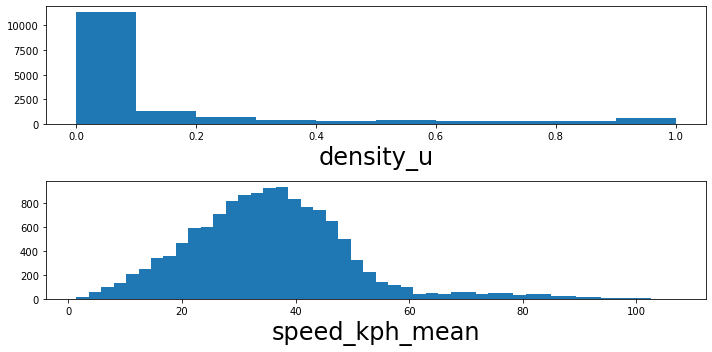

In [55]:
plot_and_stats(gdf_ut_counts_merged[gdf_ut_counts_merged["in_bb"] == True], "density_u", "speed_kph_mean")

#### density bounding box t4c

density_t                                               \
                   count      mean    median       min  max       std   
highway                                                                 
motorway             515  0.999889  1.000000  0.985714  1.0  0.001255   
motorway_link        384  0.995424  1.000000  0.028571  1.0  0.059525   
trunk                 46  0.977019  1.000000  0.742857  1.0  0.053323   
primary             2919  0.999589  1.000000  0.857143  1.0  0.004422   
primary_link          15  1.000000  1.000000  1.000000  1.0  0.000000   
secondary           6464  0.994773  1.000000  0.385714  1.0  0.021511   
secondary_link        21  0.988435  1.000000  0.800000  1.0  0.044175   
tertiary            2780  0.960468  1.000000  0.142857  1.0  0.083908   
tertiary_link          2  1.000000  1.000000  1.000000  1.0  0.000000   
unclassified          56  0.946939  1.000000  0.414286  1.0  0.131883   
residential         2934  0.838977  0.914286  0.042857  1.0  0.199248   
living_street         91  0.717896  0.700000  0.300000  1.0  0.217141   
construction           2  1.000000  1.000000  1.000000  1.0  0.000000   

               median_speed_kph                                    ...  \
                           mean     median        min         max  ...   
highway                                                            ...   
motorway              70.527832  71.333333  17.176471  113.313725  ...   
motorway_link         60.758025  63.705882   9.882353  111.411765  ...   
trunk                 47.582552  44.205882  15.686275   90.405229  ...   
primary               35.616691  35.137255   7.764706   75.647059  ...   
primary_link          31.358388  30.078431  18.176471   53.254902  ...   
secondary             34.768506  34.093137   3.764706   83.980392  ...   
secondary_link        28.506069  27.088235  11.294118   53.607843  ...   
tertiary              31.342068  30.588235   4.823529   90.764706  ...   
tertiary_link         22.632353  22.632353  14.500000   30.764706  ...   
unclassified          34.530987  36.794118   5.058824   50.450980  ...   
residential           25.604066  25.411765   1.411765   94.196078  ...   
living_street         20.208504  19.176471   4.235294   38.000000  ...   
construction          29.916667  29.916667  19.637255   40.196078  ...   

               speed_kph                         length_meters              \
                  median   min    max        std          mean      median   
highway                                                                      
motorway            80.0  40.0  120.0  11.756390    269.542609  166.226147   
motorway_link       60.0  40.0  120.0   9.972965    143.955006  116.380459   
trunk               50.0  50.0   80.0  11.395397    191.759709  113.983541   
primary             50.0  30.0   70.0   6.030589    105.425675   71.958405   
primary_link        50.0  30.0   60.0   7.745967     36.327633   23.283372   
secondary           50.0  10.0   80.0   5.288577     91.430491   66.172522   
secondary_link      50.0  50.0   50.0   0.000000     50.739361   27.290517   
tertiary            50.0  30.0   80.0   8.128033     90.187089   65.808359   
tertiary_link       50.0  50.0   50.0   0.000000     19.237726   19.237726   
unclassified        30.0  20.0   50.0  10.263315     75.866782   46.096459   
residential         30.0  10.0   50.0   7.686810    101.171479   77.107500   
living_street       50.0  50.0   50.0   0.000000    111.376050   88.298721   
construction        50.0  50.0   50.0   0.000000     36.719721   36.719721   

                                                   sort_key  
                      min          max         std           
highway                                                      
motorway         3.007915  2226.212160  322.590454        0  
motorway_link   11.935410   758.562474  117.960022        1  
trunk            3.422053   842.089303  209.688128        2  
primary          2.786192  1310.236385  

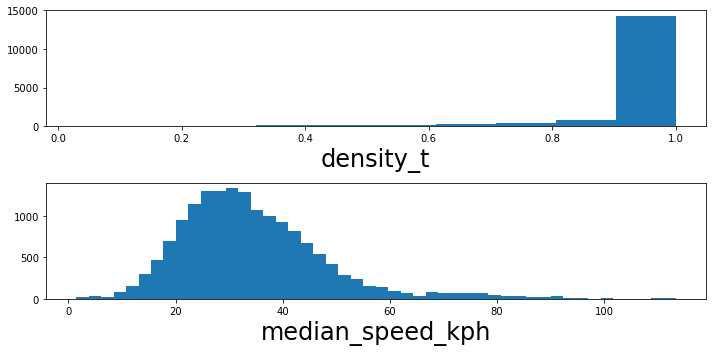

In [56]:
plot_and_stats(gdf_ut_counts_merged[gdf_ut_counts_merged["in_bb"] == True], "density_t", "median_speed_kph")

### Density and speeds for matched edges

In [57]:
# more fishy...

In [58]:
counts_all[(counts_all["matching"] == True) & ((counts_all["src"] == "t"))]

,u,v,gkey,count,speed,density,src,mean_volume,osmid,speed_kph,...,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb,sort_key,matching
5941,26985572,3937547374,26985572_3937547374_25960123,70,103.411765,1.0,t,327.950000,25960123,77.3,...,,26985572,13.241480,52.628280,3937547374,13.241103,52.634767,True,0,True
5939,26985263,26985572,26985263_26985572_4410419,70,65.598039,1.0,t,972.496429,4410419,60.0,...,,26985263,13.250590,52.616913,26985572,13.241480,52.628280,True,0,True
5937,26985226,26985225,26985226_26985225_18783891,70,65.941176,1.0,t,209.521429,18783891,60.0,...,,26985226,13.254775,52.610543,26985225,13.250866,52.612062,True,0,True
10756,32266926,246759039,32266926_246759039_22917247,70,42.519608,1.0,t,76.971429,22917247,80.0,...,,32266926,13.513540,52.428328,246759039,13.513132,52.428367,True,0,True
10754,32266902,267282985,32266902_267282985_144909695,70,78.352941,1.0,t,176.417857,144909695,80.0,...,Teltowkanalbrücke,32266902,13.520751,52.426109,267282985,13.519248,52.427128,True,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25973,5733935258,26875273,5733935258_26875273_4556847,49,19.176471,0.7,t,16.426871,4556847,50.0,...,Guerickestraße,5733935258,13.314571,52.518049,26875273,13.315415,52.517944,True,12,True
19424,1929369852,332621525,1929369852_332621525_445512538,42,28.588235,0.6,t,6.611111,445512538,50.0,...,Siemensstraße,1929369852,13.336916,52.533374,332621525,13.336462,52.533282,True,12,True
28908,2924812428,1711812139,2924812428_1711812139_4474915,70,31.852941,1.0,t,38.745238,4474915,50.0,...,Auguste-Hauschner-Straße,2924812428,13.375665,52.511308,1711812139,13.375718,52.510890,True,12,True
13626,297357680,297357794,297357680_297357794_27102690,70,40.196078,1.0,t,39.796429,27102690,50.0,...,Grenzallee,297357680,13.457966,52.466358,297357794,13.458269,52.466491,True,16,True


In [59]:
counts_all[(counts_all["matching"] == True) & ((counts_all["src"] == "u"))]

,u,v,gkey,count,speed,density,src,mean_volume,osmid,speed_kph,...,name,node_id,x_u,y_u,node_id_v,x_v,y_v,in_bb,sort_key,matching
6384,27325404,4091126131,27325404_4091126131_407076806,17,74.895,0.060714,u,NaN,407076806,80.0,...,,27325404,13.343369,52.471586,4091126131,13.340434,52.469316,True,0,True
5940,26985572,3937547374,26985572_3937547374_25960123,1,93.132,0.003571,u,NaN,25960123,77.3,...,,26985572,13.241480,52.628280,3937547374,13.241103,52.634767,True,0,True
5938,26985263,26985572,26985263_26985572_4410419,1,65.250,0.003571,u,NaN,4410419,60.0,...,,26985263,13.250590,52.616913,26985572,13.241480,52.628280,True,0,True
5936,26985226,26985225,26985226_26985225_18783891,1,68.622,0.003571,u,NaN,18783891,60.0,...,,26985226,13.254775,52.610543,26985225,13.250866,52.612062,True,0,True
10755,32266926,246759039,32266926_246759039_22917247,160,101.192,0.571429,u,NaN,22917247,80.0,...,,32266926,13.513540,52.428328,246759039,13.513132,52.428367,True,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19423,1929369852,332621525,1929369852_332621525_445512538,1,28.423,0.003571,u,NaN,445512538,50.0,...,Siemensstraße,1929369852,13.336916,52.533374,332621525,13.336462,52.533282,True,12,True
10794,33624343,29789733,33624343_29789733_26800849,1,17.158,0.003571,u,NaN,26800849,50.0,...,Graefestraße,33624343,13.416721,52.491691,29789733,13.417285,52.492424,True,12,True
19219,1846908923,2882056864,1846908923_2882056864_203910789,3,13.115,0.010714,u,NaN,203910789,50.0,...,Wiclefstraße,1846908923,13.334193,52.530578,2882056864,13.333822,52.530617,True,12,True
13627,297357794,297357680,297357794_297357680_27102690,175,16.602,0.625000,u,NaN,27102690,50.0,...,Grenzallee,297357794,13.458269,52.466491,297357680,13.457966,52.466358,True,16,True


<AxesSubplot:xlabel='highway', ylabel='density'>

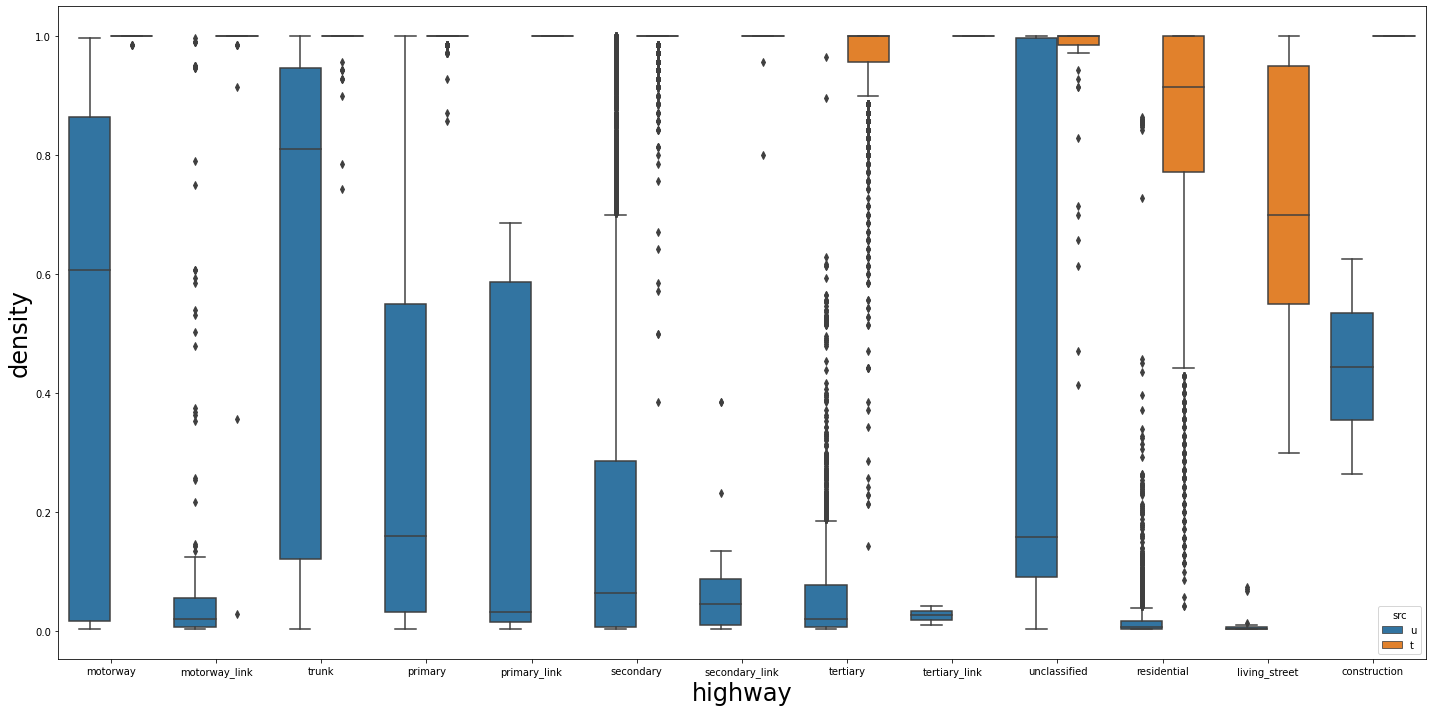

In [60]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(counts_all[counts_all["matching"] == True], x="highway", y="density", hue="src", ax=ax)

<AxesSubplot:xlabel='highway', ylabel='speed'>

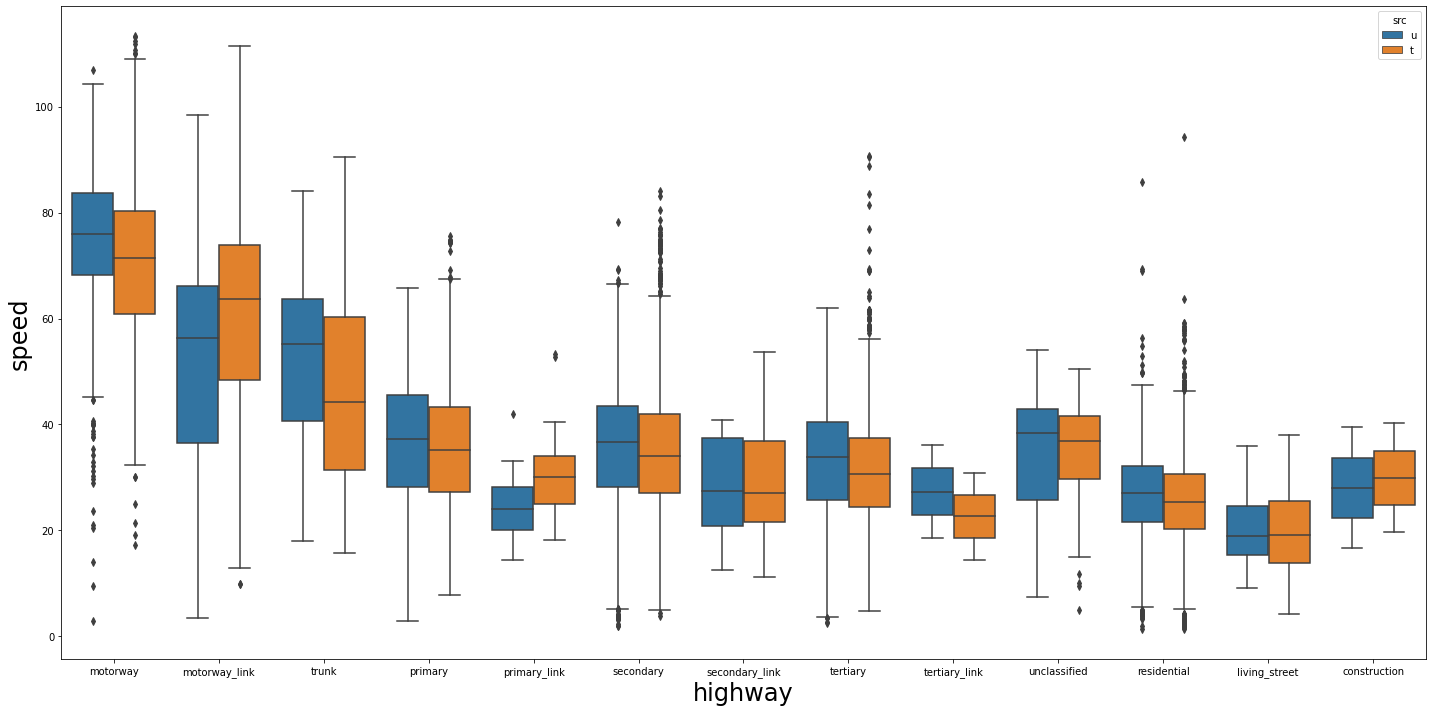

In [61]:
fig, ax = plt.subplots(1, figsize=(20, 10), tight_layout=True)
sns.boxplot(counts_all[counts_all["matching"] == True], x="highway", y="speed", hue="src", ax=ax)

In [62]:
# TODO check after daytime only
assert len(counts_all[counts_all["src"] == "t"]) == len(counts_all[(counts_all["src"] == "u") & (counts_all["matching"] == True)])

AssertionError: 

In [ ]:
plot_and_stats(counts_all[(counts_all["src"] == "u") & (counts_all["matching"] == True)], "density", "speed")

In [ ]:
plot_and_stats(counts_all[counts_all["src"] == "t"], "density", "speed")

In [ ]:
# TODO plot distribution of differences